# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
import classes.file_loader as file_loader
import classes.linear_time_series as linear_time_series

# Data Preprocessing

## Loading Files

In [3]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [4]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  classic_raw_df.fillna(method = "ffill", inplace=True)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precarity_raw_df.fillna(method = "ffill", inplace=True)


In [5]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [6]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [7]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.289782
2,2023-04-26,7.157317
3,2023-04-27,7.237827
4,2023-04-28,7.210467
...,...,...
446,2025-01-07,7.995751
447,2025-01-08,7.958149
448,2025-01-09,7.932486
449,2025-01-10,8.005431


In [8]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.254814
2,2023-04-26,7.281411
3,2023-04-27,7.352457
4,2023-04-28,7.439401
...,...,...
446,2025-01-07,10.017342
447,2025-01-08,10.043145
448,2025-01-09,9.925274
449,2025-01-10,10.119873


## Plotting the augmented dataframes 

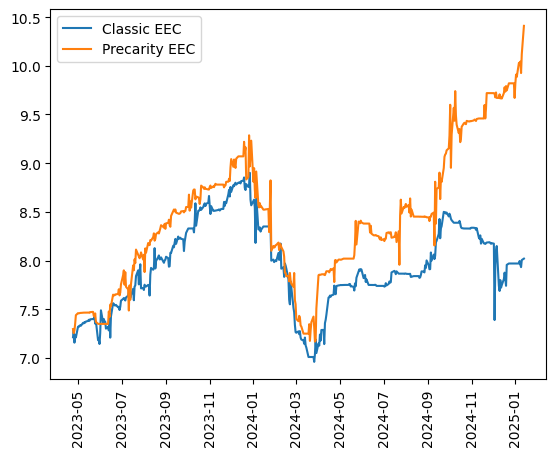

In [9]:
plt.figure()

plt.plot(augmented_classic_df["Date"], augmented_classic_df["SPOT"], label = "Classic EEC")
plt.plot(augmented_precarity_df["Date"], augmented_precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

## Classic EEC

### Tests

#### Stationnarity

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [10]:
classic_df = augmented_classic_df.copy()
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.289782,0.077066
2,2023-04-26,7.157317,-0.132465
3,2023-04-27,7.237827,0.080510
4,2023-04-28,7.210467,-0.027360
5,2023-05-01,7.321166,0.110698
...,...,...,...
446,2025-01-07,7.995751,0.025751
447,2025-01-08,7.958149,-0.037602
448,2025-01-09,7.932486,-0.025663
449,2025-01-10,8.005431,0.072945


In [11]:
result = adfuller(classic_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 3.915905853565676e-07
Result: reject unit root -> series is stationary (at 5% level).


In [12]:
precarity_df = augmented_precarity_df.copy()
precarity_df["Delta"] = precarity_df["SPOT"] - precarity_df["SPOT"].shift(1)
precarity_df.dropna(inplace = True)
precarity_df

,Date,SPOT,Delta
1,2023-04-25,7.254814,-0.041969
2,2023-04-26,7.281411,0.026597
3,2023-04-27,7.352457,0.071046
4,2023-04-28,7.439401,0.086944
5,2023-05-01,7.460184,0.020783
...,...,...,...
446,2025-01-07,10.017342,-0.012658
447,2025-01-08,10.043145,0.025803
448,2025-01-09,9.925274,-0.117871
449,2025-01-10,10.119873,0.194599


In [13]:
result = adfuller(precarity_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 0.0
Result: reject unit root -> series is stationary (at 5% level).


We separate trainning and test data to test our models predictions on out of sample data.

### ARIMA

We create an ARMA model (in reality ARIMA as the series wwas already differentiated), using a class built on our own.

In [14]:
# Initiate the ARMA class
LineaTimeSeriesModel = linear_time_series.LineaTimeSeriesModel(classic_df["Delta"])

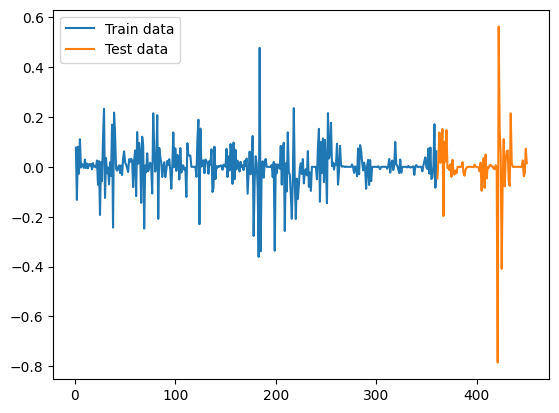

In [15]:
LineaTimeSeriesModel.train_test_split()

plt.figure()
plt.plot(LineaTimeSeriesModel.train_dependent, label="Train data")
plt.plot(LineaTimeSeriesModel.test_dependent, label="Test data")
plt.legend()
plt.show()

In [16]:
# Selecting the last relevant lags
ma_max_order = LineaTimeSeriesModel.get_ma_max_order()
ar_max_order = LineaTimeSeriesModel.get_ar_max_order()
print(f"Max MA order: {ma_max_order}, Max AR order: {ar_max_order}")

Max MA order: 1, Max AR order: 1


Now we select the best model using BIC and AIC critertions :

In [17]:
selected_models = LineaTimeSeriesModel.select_model(ma_max_order, ar_max_order)

The p-value of the L-JungBox test is 3.913464089607621e-08 for the model ARIMA(0,0,0) with AIC = -788.1891407028002
The p-value of the L-JungBox test is 0.018410220344271616 for the model ARIMA(1,0,0) with AIC = -830.4525684684115
The p-value of the L-JungBox test is 0.01588383679767056 for the model ARIMA(0,0,1) with AIC = -830.8660714440314
The p-value of the L-JungBox test is 0.03216745955869455 for the model ARIMA(1,0,1) with AIC = -830.8366947137839


c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\venv_time_series_prediction\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\venv_time_series_prediction\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\venv_time_series_prediction\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self

In [18]:
selected_models["aic"]

{'order': None, 'model': None, 'aic': inf}

### LSTM

### GRU